# Approximating a function with ResNets and ODE-Nets 

We are given a two-dimensional function and we want to approximate it with a ResNet and an ODE-Net. With the resulting models we want to compare them to see which one is more fitting and why.

First we need to choose that function.

In [2]:
import numpy as np

def function(x):
    return 3 * np.cos(x)

Now that we have created the function, we can create the ResNet and the ODE-Net.

## ResNet
Let's start with the ResNet. Before we can construct it, we need to specify its number of layers, the numbers of neurons, and other hyperparameters.

In [3]:
import numpy.random as npr

borne_g, borne_d = -10, 10

resnet_depth = 3
layer_sizes = [1, 20, 1]
param_scale = 1
step_size = 0.01
train_iters = 1000

train_set_size = 75
noise_scale = 1/4
test_set_size = 30

In [4]:
import jax.numpy as jnp
from jax.api import grad
import matplotlib.pyplot as plt

# Function that returns the output of a multi-layer perceptron
# and take the parameters of the perceptron and the inputs as an input
# Here the activation function used is tanh
def mlp(params, inputs):
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b
        inputs = jnp.tanh(outputs)
    return outputs

# Function that returns the output given by a ResNet
# of depth and weights specified in the parameters
def resnet(params, inputs, depth):
    for i in range(depth):
        outputs = mlp(params, inputs) + inputs
    return outputs

# Error function used in the training of the ResNet,
# It is the mean squared error
def resnet_squared_loss(params, inputs, targets):
    preds = resnet(params, inputs, resnet_depth)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

# Initialize the weights for the ResNet of size specified in the parameters
def init_random_params(scale, layer_sizes):
    rng = npr.RandomState(0)
    return [(scale * rng.randn(m,n), scale * rng.randn(n)) for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

# Performs an update step of the ResNet's training using the loss function defined 
# by resnet_squared_loss
# The method used here is gradient descent
def resnet_update(params, inputs, targets):
    grads = grad(resnet_squared_loss)(params, inputs, targets)
    return [(w - step_size * dw, b - step_size * db) for (w, b), (dw, db) in zip(params, grads)]

def train_resnet(train_set, test_set, noisy_targets_train, noisy_targets_test):
    resnet_params = init_random_params(param_scale, layer_sizes)
    train_errors = []
    test_errors = []
    for i in range(train_iters):
        if i % 100 == 0:
            print("Itération : ", i)
        resnet_params = resnet_update(resnet_params, train_set, noisy_targets_train)
        train_errors.append(resnet_squared_loss(resnet_params, train_set, noisy_targets_train))
        test_errors.append(resnet_squared_loss(resnet_params, test_set, noisy_targets_test))
    return resnet_params, train_errors, test_errors


def graph_errors(train_errors, test_errors):
    plt.plot(train_errors, label="Train Error")
    plt.plot(test_errors, label="Test Error")
    plt.title("Training and test errors")
    plt.xlabel("Number of iterations")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

def plot_results(inputs, noisy_targets, inputs_test, noisy_targets_test, resnet_params, resnet_depth):
    fig = plt.figure(figsize=(6, 4), dpi=150)
    ax = fig.gca()
    ax.scatter(inputs, noisy_targets, color='green')
    ax.scatter(inputs_test, noisy_targets_test, color='magenta')
    fine_inputs = jnp.reshape(jnp.linspace(borne_g-1, borne_d+1, 100), (100, 1))
    ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='red', label="ResNet")
    fine_targets = function(fine_inputs)
    ax.plot(fine_inputs, fine_targets, lw=0.5, color='blue', label = "Target")
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    plt.legend()
    plt.show()

def plot_results_ode(inputs, noisy_targets, inputs_test, noisy_targets_test, odenet_params):
    fig = plt.figure(figsize=(6, 4), dpi=150)
    ax = fig.gca()
    ax.scatter(inputs, noisy_targets, color='green')
    ax.scatter(inputs_test, noisy_targets_test, color='magenta')
    fine_inputs = jnp.reshape(jnp.linspace(borne_g-1, borne_d+1, 100), (100, 1))
    ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red', label="ODE-Net")
    fine_targets = function(fine_inputs)
    ax.plot(fine_inputs, fine_targets, lw=0.5, color='blue', label = "Target")
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    plt.legend()
    plt.show()



Now that we have everything to create the ResNet, we need data to train it. Let's create points following the function defined before.

In [5]:
from random import uniform
import numpy as np

inputs_train = jnp.reshape(np.array([uniform(borne_g,borne_d) for i in range(train_set_size)]), (train_set_size, 1))
targets_train = function(inputs_train)

noise =  npr.randn(train_set_size) * noise_scale
noise = jnp.reshape(noise, (train_set_size, 1))

noisy_targets_train = targets_train + noise

inputs_test = jnp.reshape(np.array([uniform(borne_g,borne_d) for i in range(test_set_size)]), (test_set_size, 1))
# jnp.reshape(jnp.linspace(-10, 10, test_set_size), (test_set_size, 1))
targets_test = function(inputs_test)

noise =  npr.randn(test_set_size) * noise_scale
noise = jnp.reshape(noise, (test_set_size, 1))

noisy_targets_test = targets_test + noise

We can now train the ResNet and view the results

Itération :  0
Itération :  100
Itération :  200
Itération :  300
Itération :  400
Itération :  500
Itération :  600
Itération :  700
Itération :  800
Itération :  900


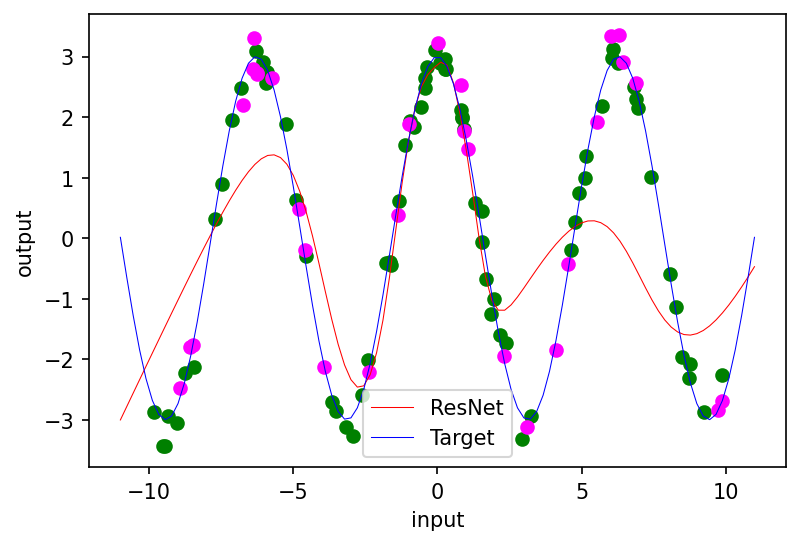

In [6]:
resnet_params, train_errors, test_errors = train_resnet(inputs_train, inputs_test, noisy_targets_train, noisy_targets_test)

plot_results(inputs_train, noisy_targets_train, inputs_test, noisy_targets_test, resnet_params, resnet_depth)

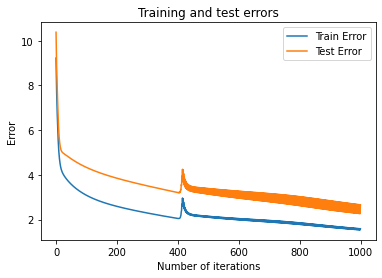

In [7]:
graph_errors(train_errors, test_errors)

## ODE-Net
We can now create an ODE-Net and train it to approximate the same function. That way we will be able to compare the two models.

First we need to choose parameters for our model. 

In [8]:
from jax.experimental.ode import odeint
from jax import vmap

odenet_layer_sizes = [2, 20, 10, 1]
param_scale = 0.2
step_size = 0.01
train_iters = 750

In [9]:
def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def odenet_update(params, inputs, targets, step_size):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def graphe(nom, fine_inputs, fine_outputs, inputs, noisy_targets, color1 = "red",  multiple = False, fine_outputs2 = None, nom2 = "", color2 = "green"):
  fig = plt.figure(figsize=(6, 4), dpi=150)
  ax = fig.gca()
  ax.scatter(inputs, noisy_targets, lw=0.5, color='indigo')
  ax.plot(fine_inputs, fine_outputs, lw=0.5, color=color1, label=nom)
  if multiple:
    ax.plot(fine_inputs, fine_outputs2, lw=0.5, color=color2, label=nom2)
  fine_targets = fine_inputs**3 + 0.1 * fine_inputs
  ax.plot(fine_inputs, fine_targets, lw=0.5, color='blue', label = "Target")
  ax.set_xlabel('input')
  ax.set_ylabel('output')
  plt.legend()
  plt.show()

def show_evol(nbr_iter, inputs, noisy_targets, fine_inputs, fine_outputs, nom, intervalle):
  if nbr_iter % intervalle == 0:
    fig = plt.figure(figsize=(6, 4), dpi=150)
    ax = fig.gca()
    ax.scatter(inputs, noisy_targets, lw=0.5, color='indigo')
    ax.plot(fine_inputs, fine_outputs, lw=0.5, color='red', label=nom)
    fine_targets = fine_inputs**3 + 0.1 * fine_inputs
    ax.plot(fine_inputs, fine_targets, lw=0.5, color='blue', label = "Target")
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    plt.legend()
    plt.show()


Itération :  0
Itération :  100
Itération :  200
Itération :  300
Itération :  400
Itération :  500
Itération :  600
Itération :  700


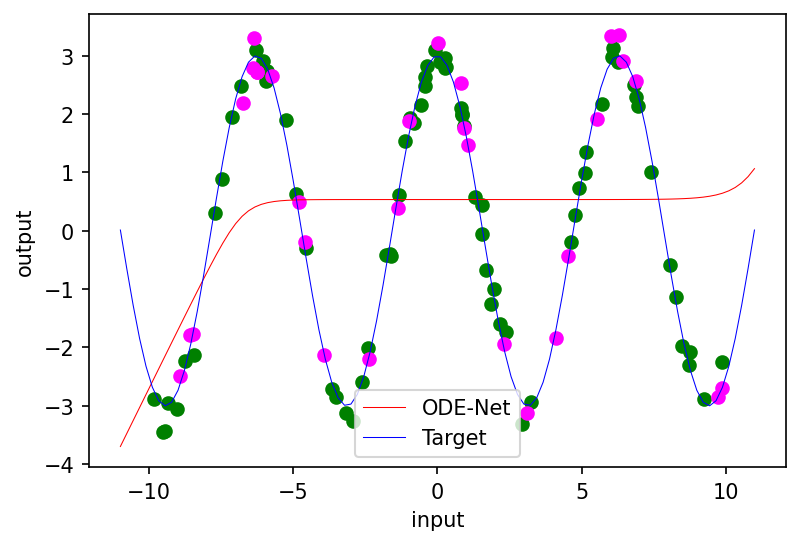

In [10]:
batched_odenet = vmap(odenet, in_axes=(None, 0))

odenet_params = init_random_params(param_scale, odenet_layer_sizes)
test_error_ode = []
train_error_ode = []
for i in range(train_iters):
    if i % 100 == 0:
        print("Itération : ", i)
    odenet_params = odenet_update(odenet_params, inputs_train, noisy_targets_train, step_size)
    test_error_ode.append(odenet_loss(odenet_params, inputs_test, noisy_targets_test))
    train_error_ode.append(odenet_loss(odenet_params, inputs_train, noisy_targets_train))
    # show_evol(i, inputs_train, noisy_targets_train, inputs_test, batched_odenet(odenet_params, inputs_test), "ODE-Net", 100)

plot_results_ode(inputs_train, noisy_targets_train, inputs_test, noisy_targets_test, odenet_params)

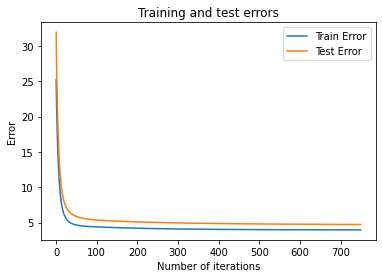

In [11]:
graph_errors(train_error_ode, test_error_ode)